In [2]:
%%capture
%cd ..

In [3]:
# Import data

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.constants import white_list

In [4]:
ds_root = 'dataset/cleaned'

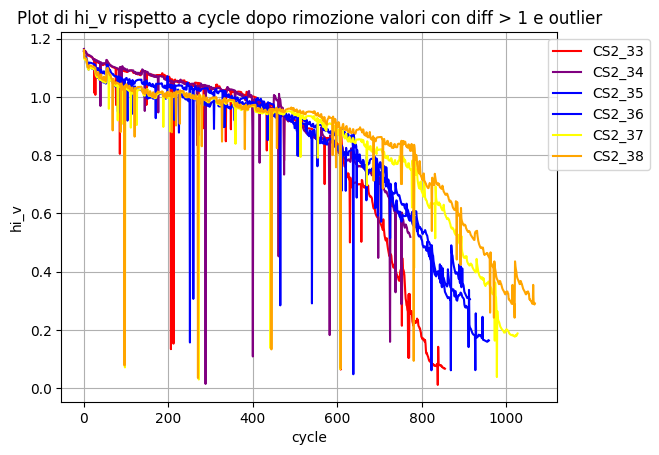

Risultati per CS2_33: [1.157049293970263, 1.1561674964824928, 1.154839692505925, 1.153415786975568, 1.1544701195348002, 1.1529562390503103, 1.1483180660210435, 1.145093063867293, 1.1429033958089692, 1.1419083629742994, 1.1431054850007492, 1.142635430705976, 1.141729388960032, 1.1409402043796693, 1.1402437099479332, 1.1394288256763172, 1.1384374893280498, 1.137697317910412, 1.1369042170712156, 1.1361110913127206, 1.135313384416591, 1.1340264654287715, 1.1289573749941333, 1.126907610758952, 1.1251993910153928, 1.0132520262447002, 1.12861375192956, 1.0073151988045481, 1.1231577369842825, 1.1216568167363334, 1.120888799445673, 1.123981338497238, 1.1220059888424743, 1.1185101754268487, 1.1175622334486164, 1.1164152473000257, 1.1184222302426434, 1.1198980193963166, 1.1155550131070342, 1.1144065196828876, 1.1133759404298402, 1.1136117600311337, 1.1157549044535884, 1.1125284111046838, 1.110123570325861, 1.1093985164469942, 1.1100180778635647, 1.1121332831309942, 1.1124563265956198, 1.112583277

In [9]:
# Lista dei colori che vuoi utilizzare per le curve
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

# Inizializza il plot
plt.figure()

# Lista per i nomi dei file
file_names = []

# Dizionario per memorizzare i risultati di ogni file
results_dict = {}

# Loop attraverso i file in ds_root
for i, file_name in enumerate(os.listdir(ds_root)):
    file_path = os.path.join(ds_root, file_name)
    if file_name.startswith('charge'):
        df = pd.read_csv(file_path)

        first_step_index_2 = df[df['Step_Index'] == 2].groupby('Cycle_Index').head(1)
        last_step_index_4 = df[df['Step_Index'] == 4].groupby('Cycle_Index').tail(1)
        cycle_indexes2 = first_step_index_2['Cycle_Index'].index  # ha indice riga e numero del ciclo
        cycle_indexes4 = last_step_index_4['Cycle_Index'].index

        first = []
        for i in cycle_indexes2:
            first.append(df.iloc[i, 6])

        last = []
        for i in cycle_indexes4:
            last.append(df.iloc[i, 6])

        result = [b - a for a, b in zip(first, last)]
        cs2x_part = file_name.split('charge-')[1].split('.csv')[0]
        file_names.append(cs2x_part)

        # Salva i risultati nel dizionario solo se non sono già presenti
        if cs2x_part not in results_dict:
            results_dict[cs2x_part] = result

        # Traccia la curva utilizzando un colore dalla lista colors
        plt.plot(result, label=f'{cs2x_part}', linestyle='-', color=colors[i % len(colors)])

# Aggiungi titoli e legenda
plt.title('Plot di hi_v rispetto a cycle dopo rimozione valori con diff > 1')
plt.xlabel('cycle')
plt.ylabel('soh')
plt.grid(True)

# Sposta la legenda in alto a destra senza che esca dalla figura
plt.legend(file_names, loc='upper right', bbox_to_anchor=(1.2, 1.))

# Mostra il plot
plt.show()



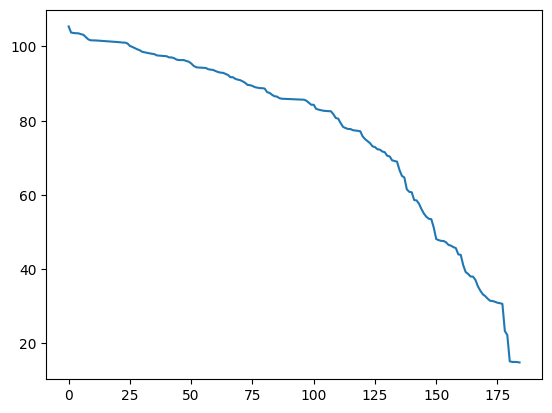

In [6]:
for i in range(len(result) - 1, 0, -1):
    
    if result[i - 1] <= result[i]:
        del result[i - 1]


valori = []
for j in range(len(result)):
    val = (result[j]/(1.1))
    val = val*100
    valori.append(val)



plt.plot(valori)

In [ ]:
# first_step_index_2 = cleaned[cleaned['Step_Index'] == 2].groupby('Cycle_Index').head(1)
# last_step_index_4 = cleaned[cleaned['Step_Index'] == 4].groupby('Cycle_Index').tail(1)
# cycle_indexes2 = first_step_index_2['Cycle_Index'].index # ha indice riga e numero del ciclo
# cycle_indexes4 = last_step_index_4['Cycle_Index'].index 

# first = []
# for i in cycle_indexes2:
#     first.append(cleaned.iloc[i,6])

# last = []
# for i in cycle_indexes4:
#     last.append(cleaned.iloc[i,6])
    
# result = [b - a for a, b in zip(first, last)]
# print(result)

# dim = len(result)
# print(dim)

# plt.plot(result)